<a href="https://colab.research.google.com/github/reidnclark/MFDPRepo/blob/main/Multipurpose_Financial_Data_Processor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Custom Porfolio Monte Carlo Forecaster**
### Instructions:

---

#### 2 types of cells, **Run Cell** and **Edit & Run Cell**.

---


##### - For Run Cells, simply click the play button in the top left corner of the code block.

##### - For Edit & Run Cells, edit values after the '=' sign, then run the cell as mentioned above.

---

#### *Run Cell (Import Libraries):*

###### Uses Yahoo! Finance API

---

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import gaussian_kde, norm

#### *Run Cell (Define Functions):*

---

In [ ]:
def normalize_weights(portfolio, individual_weights):
    total_weight = sum(individual_weights)
    return [w / total_weight for w in individual_weights]

def get_historical_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for ticker in tickers:
        ticker_data = yf.download(ticker, start=start_date, end=end_date)["Adj Close"]
        data[ticker] = ticker_data
    return data

def monte_carlo_simulation(portfolio, weights, start_date, end_date, num_simulations, num_days):
    try:
        portfolio_prices = get_historical_data(portfolio, start_date, end_date)
        portfolio_daily_returns = portfolio_prices.pct_change().dropna()
        portfolio_mean_returns = portfolio_daily_returns.mean()
        portfolio_cov_matrix = portfolio_daily_returns.cov()

        simulated_portfolio_values = []
        for i in range(num_simulations):
            random_returns = np.random.multivariate_normal(portfolio_mean_returns, portfolio_cov_matrix, num_days)
            simulated_prices = np.zeros((num_days, len(portfolio)))
            simulated_prices[0, :] = portfolio_prices.iloc[-1, :].values

            for j in range(1, num_days):
                simulated_prices[j, :] = simulated_prices[j - 1, :] * (1 + random_returns[j])

            simulated_portfolio_value = np.dot(simulated_prices, weights)
            simulated_portfolio_values.append(simulated_portfolio_value)

        simulations_portfolio = pd.DataFrame(simulated_portfolio_values).T
        simulations_portfolio.columns = [f'Simulation_{i+1}' for i in range(num_simulations)]

        return simulations_portfolio

    except Exception as e:
        print(f"Error in Monte Carlo simulation for portfolio: {str(e)}")
        return None

def benchmark_simulation(ticker, start_date, end_date, num_simulations, num_days):
    try:
        benchmark_prices = get_historical_data([ticker], start_date, end_date)
        benchmark_daily_returns = benchmark_prices.pct_change().dropna()
        benchmark_mean_return = benchmark_daily_returns.mean()
        benchmark_std_dev = benchmark_daily_returns.std()

        simulated_benchmark_values = []
        for i in range(num_simulations):
            random_returns = np.random.normal(benchmark_mean_return, benchmark_std_dev, num_days)
            simulated_prices = np.zeros(num_days)
            simulated_prices[0] = benchmark_prices.iloc[-1, 0]

            for j in range(1, num_days):
                simulated_prices[j] = simulated_prices[j - 1] * (1 + random_returns[j])

            simulated_benchmark_value = simulated_prices[-1]
            simulated_benchmark_values.append(simulated_benchmark_value)

        return np.array(simulated_benchmark_values)

    except Exception as e:
        print(f"Error in benchmark simulation: {str(e)}")
        return None

def calculate_returns(simulations_portfolio, initial_capital):
    daily_returns = simulations_portfolio.pct_change().dropna()
    cumulative_returns = (1 + daily_returns).cumprod()
    annualized_returns = (cumulative_returns.iloc[-1, :] ** (252 / len(cumulative_returns))) - 1

    mean_return = annualized_returns.mean()
    std_dev = annualized_returns.std()
    base_return = mean_return
    bull_returns = mean_return + std_dev
    bear_returns = mean_return - std_dev

    return base_return, bull_returns, bear_returns, annualized_returns

def plot_histogram_combined(percentage_gains_large_portfolio, percentage_gains_vfv_portfolio):
    plt.figure(figsize=(10, 6))

    plt.hist(percentage_gains_large_portfolio, bins=50, density=True, color='pink', alpha=0.7, edgecolor='black')
    kde_large = gaussian_kde(percentage_gains_large_portfolio)
    x_large = np.linspace(min(percentage_gains_large_portfolio), max(percentage_gains_large_portfolio), 1000)
    plt.plot(x_large, kde_large(x_large), color='red', linewidth=2, label='Custom Portfolio KDE')

    mean_large_portfolio = np.mean(percentage_gains_large_portfolio)
    plt.axvline(mean_large_portfolio, color='red', linestyle='dashed', linewidth=2, label='Mean Return Custom Portfolio')

    plt.hist(percentage_gains_vfv_portfolio, bins=50, density=True, color='lightgreen', alpha=0.4, edgecolor='black')
    kde_vfv = gaussian_kde(percentage_gains_vfv_portfolio)
    x_vfv = np.linspace(min(percentage_gains_vfv_portfolio), max(percentage_gains_vfv_portfolio), 1000)
    plt.plot(x_vfv, kde_vfv(x_vfv), color='darkgreen', linewidth=2, label=f'{benchmark_ticker} Portfolio KDE')

    mean_vfv_portfolio = np.mean(percentage_gains_vfv_portfolio)
    plt.axvline(mean_vfv_portfolio, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean Return Benchmark ({benchmark_ticker}) Portfolio')

    plt.xlabel('Percentage Gain (%)')
    plt.ylabel('Probability Density (Likelihood of return on x axis)')
    plt.title('Histogram and KDE of Percentage Gains from Monte Carlo Simulations')
    plt.legend()
    plt.tight_layout()
    plt.show()

#### *Edit & Run Cell (Add Stocks):*

###### Enter portfolio tickers here, separated by commas.

###### Reference Yahoo! Finance for ticker formatting (e.g. VFV in your Canadian portfolio may only register as VFV.TO)
---

In [ ]:
# Format tickers as: portfolio = ['TICKER1','TICKER2','TICKER3', ...]

portfolio = ['MCO', 'V', # Financials: Moody's Corp, Visa
             'ATD.TO', # Consumer Cyclical: Alimentation Couche-Tard
             'HUC.TO', 'CCO.TO', 'U-UN.TO', # Energy: Crude Oil ETF GlobalX, Cameco Corp, Sprott Physical Uranium
             'K.TO', 'PHYS', 'TECK-B.TO', # Materials: Kinross Gold, Sprott Physical Gold, Teck Resources
             'RYCEY', 'HTHIY', # Industrials: Rolls-Royce Aerospace Engines, Hitachi Ltd
             'AAPL', 'MSFT', 'MOD', # Technology: Apple Inc, Microsoft, Modine Manufacturing Co
             'VFV.TO', # Vanguard S&P 500
             ]

In [ ]:
# secret stocks !
# -----------
# keyera corp
# american water works
# linde plc
# amphenol

#### *Edit & Run Cell (Define Stock Weights):*

###### Enter portfolio weights here.

###### Individual weights automatically sets the value of each ticker as 1.

###### If you want to allocate more or less to a certain stock, change the individual weight value to anything between 0 and infinity.

###### The script will then normalize your weights automatically relative to the total portfolio value.

###### Note: ticker intervals begin at 0, not 1. The first stock in your portfolio is designated as '0'

---

In [ ]:
# Standard values set as '1'
# Do not Modify

individual_weights = [1] * len(portfolio)

# Modify individual values here (delete hashtag to make active. Copy and paste to add more individual weights):
#individual_weights[0] = 0.15
#individual_weights[1] = 0.25

#### *Edit & Run Cell (Enter Initial Capital):*

---

In [ ]:
initial_capital = 10  # initial capital in USD $1,700,000,000

#### *Edit & Run Cell (Enter Data Analysis Period Dates):*

###### Alter the start and end dates for historical analysis (volatility, annual returns).

###### This should be a timeframe you feel is relevant to the future behaviour of the stocks in your portfolio, or a time period length you are interested in analyzing.

###### This current script version cannot analyze individual periods per stock (e.g. would be beneficial to ignore recessive periods for targeted analyses).

---

In [ ]:
# Formatted 'YYYY-MM-DD'

start_date_str = '2019-07-01'
end_date_str = '2023-07-01'

#### *Edit & Run Cell (Enter Risk-Free Rate):*

###### Enter risk-free rate (e.g. GIC rate) for sharpe ratio and similar risk-return analyses

---

In [ ]:
# Example risk-free rate entry (4.5% = 0.045)

risk_free_rate = 0.03

#### *Edit & Run Cell (Enter Benchmark):*

###### Enter benchmark (standard is S&P 500) for distribution comparison.

---

In [ ]:
benchmark_ticker = 'VFV.TO'

#### *Edit & Run Cell (Enter Monte Carlo Parameters):*

###### Alter number of simulation iterations (standard is between 500 - 5,000 for this script)

###### Alter number of simulation days (standard is 252 for trading days in a year)

---

In [ ]:
num_simulations = 2000  # Number of simulations

num_days = 252  # Number of trading days

#### *Run Cell (Results):*

---

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


--------------------------------------------------
Monte Carlo Simulation Results for Large Portfolio:
Mean Annualized Return: 29.30%
Standard Deviation of Returns: 34.10%

Sharpe Ratio: 0.86

Initial Capital: $10
Base Scenario: Return = 29.30%
Bull Scenario: Return = 63.40%
Bear Scenario: Return = -4.80%
--------------------------------------------------



Monte Carlo Simulation Results for Benchmark (VFV.TO) Portfolio:
Mean Annualized Return: 14.98%
Standard Deviation of Returns: 24.07%

Sharpe Ratio: 0.62

Base Scenario: Return = 14.98%
Bull Scenario: Return = 39.05%
Bear Scenario: Return = -9.09%
--------------------------------------------------



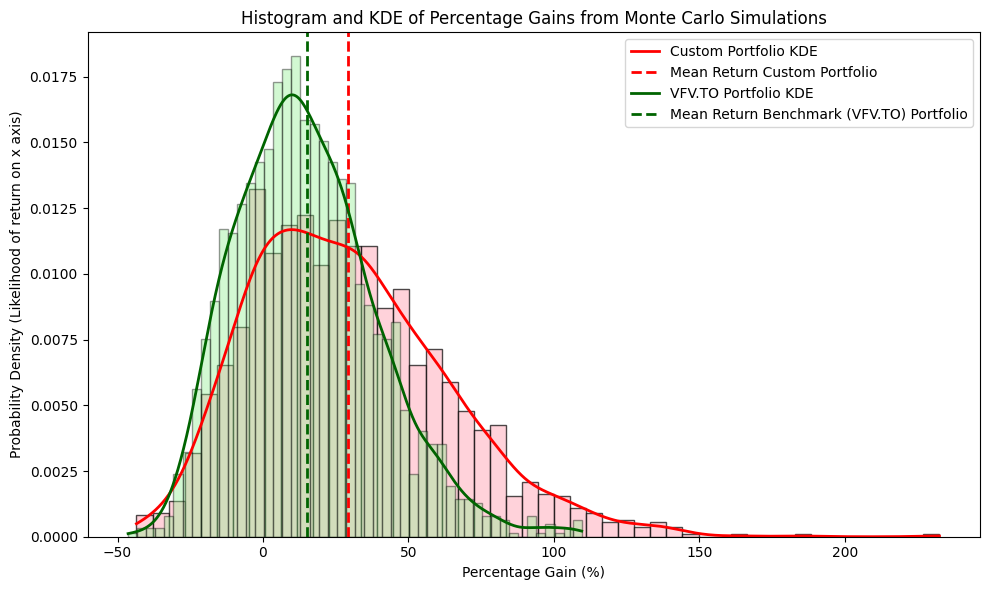

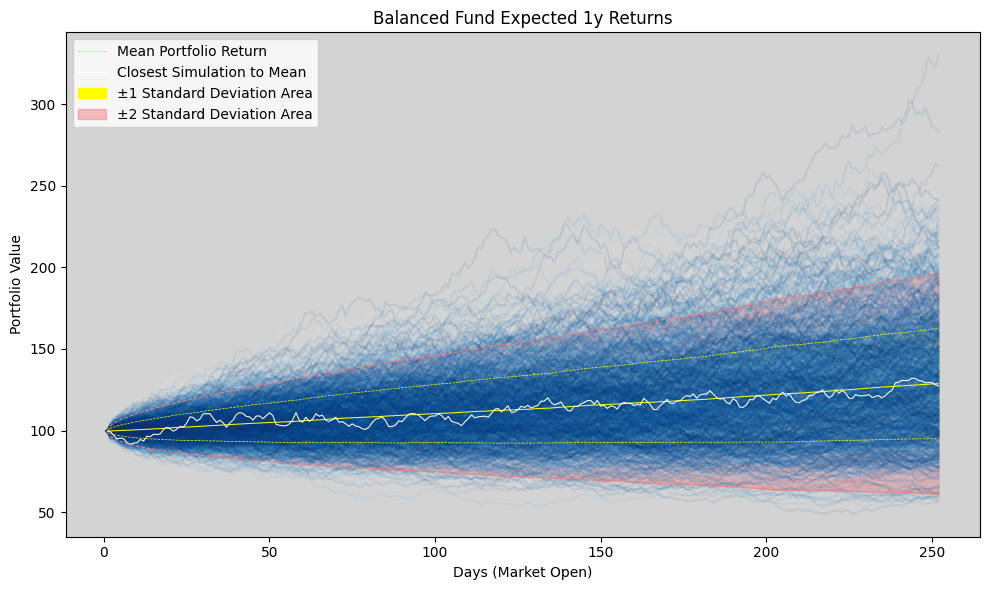

In [ ]:
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

weights_large_portfolio = normalize_weights(portfolio, individual_weights)

simulations_portfolio = monte_carlo_simulation(portfolio, weights_large_portfolio, start_date, end_date, num_simulations, num_days)

benchmark_simulated_values_vfv = benchmark_simulation(benchmark_ticker, start_date_str, end_date_str, num_simulations, num_days)

if simulations_portfolio is not None and benchmark_simulated_values_vfv is not None:
    base_return_large, bull_returns_large, bear_returns_large, portfolio_returns_large = calculate_returns(simulations_portfolio, initial_capital)
    mean_return_large = portfolio_returns_large.mean() * 100
    std_dev_large = portfolio_returns_large.std() * 100
    print('')
    print('--------------------------------------------------')
    print('Monte Carlo Simulation Results for Large Portfolio:')
    print(f'Mean Annualized Return: {mean_return_large:.2f}%')
    print(f'Standard Deviation of Returns: {std_dev_large:.2f}%')
    print()

    sharpe_ratio_large = (mean_return_large - risk_free_rate) / std_dev_large
    print(f'Sharpe Ratio: {sharpe_ratio_large:.2f}')
    print()
    print(f'Initial Capital: ${initial_capital:,}')
    print(f'Base Scenario: Return = {base_return_large * 100:.2f}%')
    print(f'Bull Scenario: Return = {bull_returns_large * 100:.2f}%')
    print(f'Bear Scenario: Return = {bear_returns_large * 100:.2f}%')
    print('--------------------------------------------------')
    print()

    final_portfolio_values_large = simulations_portfolio.iloc[-1, :]
    percentage_gains_large = (final_portfolio_values_large - initial_capital) / initial_capital * 100
    percentage_gains_large = portfolio_returns_large * 100

    simulations_vfv_portfolio = monte_carlo_simulation(['VFV.TO'], [1], start_date, end_date, num_simulations, num_days)

    base_return_vfv, bull_returns_vfv, bear_returns_vfv, portfolio_returns_vfv = calculate_returns(simulations_vfv_portfolio, initial_capital)
    mean_return_vfv = portfolio_returns_vfv.mean() * 100
    std_dev_vfv = portfolio_returns_vfv.std() * 100

    print(f'Monte Carlo Simulation Results for Benchmark ({benchmark_ticker}) Portfolio:')
    print(f'Mean Annualized Return: {mean_return_vfv:.2f}%')
    print(f'Standard Deviation of Returns: {std_dev_vfv:.2f}%')
    print()

    sharpe_ratio_vfv = (mean_return_vfv - risk_free_rate) / std_dev_vfv
    print(f'Sharpe Ratio: {sharpe_ratio_vfv:.2f}')
    print()
    print(f'Base Scenario: Return = {base_return_vfv * 100:.2f}%')
    print(f'Bull Scenario: Return = {bull_returns_vfv * 100:.2f}%')
    print(f'Bear Scenario: Return = {bear_returns_vfv * 100:.2f}%')
    print('--------------------------------------------------')
    print()

    final_portfolio_values_vfv = simulations_vfv_portfolio.iloc[-1, :]
    percentage_gains_vfv = (final_portfolio_values_vfv - initial_capital) / initial_capital * 100
    percentage_gains_vfv = portfolio_returns_vfv * 100

    plot_histogram_combined(percentage_gains_large, percentage_gains_vfv)

    plt.figure(figsize=(10, 6))

    for i in range(num_simulations):
        plt.plot(range(1, num_days + 1), simulations_portfolio[f'Simulation_{i+1}'], color=plt.cm.Blues(i / num_simulations), alpha=0.1)

    ax = plt.subplot(111)
    ax.set_facecolor('lightgray')

    mean_portfolio = simulations_portfolio.mean(axis=1)
    plt.plot(range(1, num_days + 1), mean_portfolio, color='yellow', linewidth=0.75, label='Mean Portfolio Return')

    differences = (simulations_portfolio - mean_portfolio.values[:, None]).abs().sum(axis=0)
    closest_simulation_index = differences.idxmin()
    closest_simulation = simulations_portfolio.iloc[:, simulations_portfolio.columns.get_loc(closest_simulation_index)]

    plt.plot(range(1, num_days + 1), closest_simulation, color='white', linewidth=0.75, label='Closest Simulation to Mean')

    std_dev_upper_portfolio = mean_portfolio + simulations_portfolio.std(axis=1)
    std_dev_lower_portfolio = mean_portfolio - simulations_portfolio.std(axis=1)

    plt.fill_between(range(1, num_days + 1), std_dev_upper_portfolio, std_dev_lower_portfolio, color='yellow', alpha=1, label='±1 Standard Deviation Area')
    plt.plot(range(1, num_days + 1), std_dev_upper_portfolio, color='yellow', linestyle='--', linewidth=0.5)
    plt.plot(range(1, num_days + 1), std_dev_lower_portfolio, color='yellow', linestyle='--', linewidth=0.5)

    std_dev_2_upper = mean_portfolio + 2 * simulations_portfolio.std(axis=1)
    std_dev_2_lower = mean_portfolio - 2 * simulations_portfolio.std(axis=1)

    plt.fill_between(range(1, num_days + 1), std_dev_2_upper, std_dev_2_lower, color='lightcoral', alpha=0.5, label='±2 Standard Deviation Area')
    plt.plot(range(1, num_days + 1), std_dev_2_upper, color='lightcoral', linestyle='--', linewidth=0.75)
    plt.plot(range(1, num_days + 1), std_dev_2_lower, color='lightcoral', linestyle='--', linewidth=0.75)

    plt.xlabel('Days (Market Open)')
    plt.ylabel('Portfolio Value')
    plt.title('Balanced Fund Expected 1y Returns')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("Error in simulations. Check the inputs and try again.")


END

---

FULL RAW CODE BELOW

---

---

---